In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

# Data Loading and Cleaning

# Feature Engineering

In [2]:
df = pd.read_csv('./Data/processed/nse_all_clean.csv')
df

,Date,Stock_code,Name,12m Low,12m High,Day Low,Day High,Day Price,Previous,Change,%Change,Volume,Adjusted Price,Sector
0,2021-01-04,ABSA,ABSA Bank Kenya Plc,8.50,14.20,9.42,9.80,9.52,9.66,-0.14,1.45,18500.0,0.0,Banking
1,2021-01-05,ABSA,ABSA Bank Kenya Plc,8.50,14.20,9.44,9.70,9.44,9.52,-0.08,0.84,1923300.0,0.0,Banking
2,2021-01-06,ABSA,ABSA Bank Kenya Plc,8.50,14.20,9.40,9.68,9.44,9.44,0.00,0.00,233400.0,0.0,Banking
3,2021-01-07,ABSA,ABSA Bank Kenya Plc,8.50,14.20,9.36,9.46,9.40,9.44,-0.04,0.42,194700.0,0.0,Banking
4,2021-01-11,ABSA,ABSA Bank Kenya Plc,8.50,14.20,9.44,9.70,9.46,9.48,-0.02,0.21,77900.0,0.0,Banking
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69940,2024-12-23,^ZKEQTU,Zamara Kenya Equity Index (USD),818.46,1633.43,1633.26,1633.26,1633.26,1633.43,-0.17,-0.01,0.0,0.0,Indices
69941,2024-12-24,^ZKEQTU,Zamara Kenya Equity Index (USD),818.46,1662.24,1638.08,1638.08,1638.08,1633.26,4.82,0.30,0.0,0.0,Indices
69942,2024-12-27,^ZKEQTU,Zamara Kenya Equity Index (USD),818.46,1648.20,1648.20,1648.20,1648.20,1638.08,10.12,0.62,0.0,0.0,Indices
69943,2024-12-30,^ZKEQTU,Zamara Kenya Equity Index (USD),818.46,1662.24,1662.24,1662.24,1662.24,1648.20,14.04,0.85,0.0,0.0,Indices


In [3]:
# Feature Engineering Functions 

# Calculate daily returns for a stock.

def calculate_returns(group):
    group = group.sort_values('Date').copy()
    group['daily_return'] = group['Day Price'].pct_change()
    return group

# Calculating rolling volatility metrics.
def calculate_volatility_features(group, windows=[7, 14, 30]):
    group = group.sort_values('Date').copy()
    
    for window in windows:
        group[f'volatility_{window}d'] = group['daily_return'].rolling(
            window=window, min_periods=max(3, window//2)
        ).std()
    
    return group

# Calculate liquidity-related features.
def calculate_liquidity_features(group):
    
    group = group.sort_values('Date').copy()
    
    group['avg_volume'] = group['Volume'].rolling(window=30, min_periods=10).mean()
    group['volume_volatility'] = group['Volume'].rolling(window=30, min_periods=10).std()
    group['zero_volume_days'] = group['Volume'].rolling(window=30, min_periods=10).apply(
        lambda x: (x == 0).sum() if x.notna().sum() > 0 else np.nan
    )
    
    return group

# Calculating momentum and trend indicators.
def calculate_momentum_features(group):
    group = group.sort_values('Date').copy()
    
    group['momentum_30d'] = group['Day Price'].pct_change(periods=30)
    group['ma_7'] = group['Day Price'].rolling(window=7, min_periods=3).mean()
    group['ma_30'] = group['Day Price'].rolling(window=30, min_periods=10).mean()
    group['price_to_ma30'] = (group['Day Price'] - group['ma_30']) / group['ma_30']
    
    return group

# Calculate maximum drawdown.
def calculate_drawdown(group):
    group = group.sort_values('Date').copy()
    
    running_max = group['Day Price'].expanding().max()
    drawdown = (group['Day Price'] - running_max) / running_max
    
    group['current_drawdown'] = drawdown
    group['max_drawdown'] = group['current_drawdown'].expanding().min()
    
    return group

# Aggregate features at stock level.
def aggregate_stock_features(group):
    
    active_days = group[(group['Volume'].notna()) & (group['Volume'] > 0)]
    
    if len(active_days) < 20:
        return None
    
    features = {
        'Stock_code': group['Stock_code'].iloc[0],
        'Sector': group['Sector'].iloc[0] if 'Sector' in group.columns else None,
        'Name': group['Name'].iloc[0] if 'Name' in group.columns else None,
        
        'trading_days': len(active_days),
        'total_days': len(group),
        'trading_frequency': len(active_days) / len(group),
        
        'mean_return': active_days['daily_return'].mean(),
        'std_return': active_days['daily_return'].std(),
        
        'volatility_7d': group['volatility_7d'].mean() if 'volatility_7d' in group.columns else 0,
        'volatility_30d': group['volatility_30d'].mean() if 'volatility_30d' in group.columns else 0,
        
        'max_drawdown': group['max_drawdown'].min() if 'max_drawdown' in group.columns else 0,
        
        'avg_volume': active_days['Volume'].mean(),
        'zero_volume_ratio': (group['Volume'] == 0).sum() / len(group),
        
        'momentum_30d': group['momentum_30d'].iloc[-1] if 'momentum_30d' in group.columns else 0,
        'current_price': group['Day Price'].iloc[-1]
    }
    
    return features

In [4]:
# Applying feature engineering to df

print("Calculating returns")
df = df.groupby('Stock_code', group_keys=False).apply(calculate_returns).reset_index(drop=True)

print("Calculating volatility")
df = df.groupby('Stock_code', group_keys=False).apply(calculate_volatility_features).reset_index(drop=True)

print("Calculating liquidity")
df = df.groupby('Stock_code', group_keys=False).apply(calculate_liquidity_features).reset_index(drop=True)

print("Calculating momentum")
df = df.groupby('Stock_code', group_keys=False).apply(calculate_momentum_features).reset_index(drop=True)

print("Calculating drawdown...")
df = df.groupby('Stock_code', group_keys=False).apply(calculate_drawdown).reset_index(drop=True)

print("\nAggregating to stock level")
features_list = []
for Stock_code, group in df.groupby('Stock_code'):
    stock_features = aggregate_stock_features(group)
    if stock_features is not None:
        features_list.append(stock_features)

df_features = pd.DataFrame(features_list)

df_features.head()

Calculating returns
Calculating volatility
Calculating liquidity
Calculating momentum
Calculating drawdown...

Aggregating to stock level


,Stock_code,Sector,Name,trading_days,total_days,trading_frequency,mean_return,std_return,volatility_7d,volatility_30d,max_drawdown,avg_volume,zero_volume_ratio,momentum_30d,current_price
0,ABSA,Banking,ABSA Bank Kenya Plc,988,988,1.000000,0.000743,0.013638,0.011135,0.012541,-0.236220,457918.016194,0.000000,0.160772,18.05
1,BAMB,Construction and Allied,Bamburi Cement Ltd,974,988,0.985830,0.000901,0.028007,0.021978,0.024157,-0.514563,233655.667351,0.014170,-0.176030,55.00
2,BAT,Manufacturing and Allied,British American Tobacco Kenya Plc,936,988,0.947368,0.000126,0.013762,0.010576,0.012213,-0.348232,19173.611111,0.052632,0.059155,376.00
3,BKG,Banking,BK Group Plc,592,988,0.599190,0.001923,0.038372,0.025778,0.028502,-0.392500,86221.114865,0.400810,-0.012140,32.55
4,BOC,Manufacturing and Allied,BOC Kenya Plc,402,988,0.406883,0.001758,0.042706,0.021544,0.026053,-0.302949,10246.268657,0.593117,-0.002809,88.75


In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

features = df_features[["std_return", "volatility_30d", "max_drawdown"]].copy()
features["drawdown_abs"] = -features["max_drawdown"]
features = features.drop(columns=["max_drawdown"])
features


scaler = StandardScaler()
X = scaler.fit_transform(features)

kmeans = KMeans(n_clusters=3, random_state=42)
df_features["cluster"] = kmeans.fit_predict(X)

summary = df_features.groupby("cluster")[["std_return", "volatility_30d"]].mean()
summary["drawdown_abs"] = df_features.groupby("cluster")["max_drawdown"].mean() * -1

summary["risk_score"] = (
    summary["std_return"]
    + summary["volatility_30d"]
    + summary["drawdown_abs"]
)

ordered = summary.sort_values("risk_score").index.tolist()

df_features["risk_level"] = df_features["cluster"].map({
    ordered[0]: "Low Risk",
    ordered[1]: "Medium Risk",
    ordered[2]: "High Risk"
})
df_features


,Stock_code,Sector,Name,trading_days,total_days,trading_frequency,mean_return,std_return,volatility_7d,volatility_30d,max_drawdown,avg_volume,zero_volume_ratio,momentum_30d,current_price,cluster,risk_level,pca_1,pca_2
0,ABSA,Banking,ABSA Bank Kenya Plc,988,988,1.000000,0.000743,0.013638,0.011135,0.012541,-0.236220,4.579180e+05,0.000000,0.160772,18.05,1,Medium Risk,-2.586549,-0.189866
1,BAMB,Construction and Allied,Bamburi Cement Ltd,974,988,0.985830,0.000901,0.028007,0.021978,0.024157,-0.514563,2.336557e+05,0.014170,-0.176030,55.00,1,Medium Risk,-0.289235,-0.463179
2,BAT,Manufacturing and Allied,British American Tobacco Kenya Plc,936,988,0.947368,0.000126,0.013762,0.010576,0.012213,-0.348232,1.917361e+04,0.052632,0.059155,376.00,1,Medium Risk,-2.274505,-0.651047
3,BKG,Banking,BK Group Plc,592,988,0.599190,0.001923,0.038372,0.025778,0.028502,-0.392500,8.622111e+04,0.400810,-0.012140,32.55,2,High Risk,0.149479,0.676653
4,BOC,Manufacturing and Allied,BOC Kenya Plc,402,988,0.406883,0.001758,0.042706,0.021544,0.026053,-0.302949,1.024627e+04,0.593117,-0.002809,88.75,0,Low Risk,-0.068222,1.302484
5,BRIT,Insurance,Britam Holdings Plc,987,988,0.998988,0.000109,0.024529,0.023085,0.023619,-0.516706,2.842834e+05,0.001012,-0.026846,5.80,1,Medium Risk,-0.487973,-0.681075
6,CABL,Construction and Allied,East African Cables Ltd,982,988,0.993927,0.000319,0.034200,0.033281,0.033784,-0.543750,1.954348e+04,0.006073,-0.027027,1.08,2,High Risk,0.747212,-0.189359
7,CARB,Manufacturing and Allied,Carbacid Investments Plc,977,988,0.988866,0.000820,0.022922,0.020379,0.021778,-0.304979,4.645742e+04,0.011134,0.050125,20.95,1,Medium Risk,-1.310598,0.102058
8,CGEN,Automobiles and Accessories,Car and General (K) Ltd,571,988,0.577935,0.000883,0.049197,0.031767,0.036251,-0.751974,1.480736e+03,0.422065,0.008869,22.75,2,High Risk,2.251213,-0.157418
9,CIC,Insurance,CIC Insurance Group Ltd,988,988,1.000000,0.000364,0.026326,0.024577,0.025869,-0.504425,1.254372e+05,0.000000,-0.048673,2.15,1,Medium Risk,-0.284746,-0.516476


In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# ---- PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)   # X is the scaled feature matrix you used for KMeans

df_features["pca_1"] = X_pca[:, 0]
df_features["pca_2"] = X_pca[:, 1]


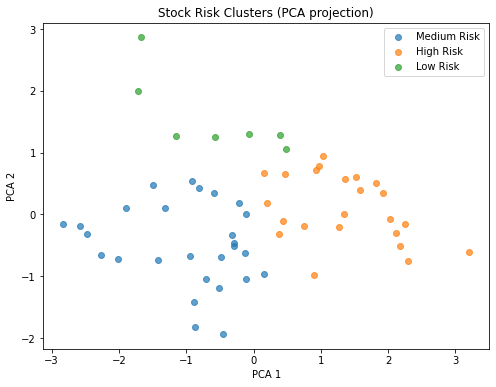

In [18]:
plt.figure(figsize=(8,6))

for level in df_features["risk_level"].unique():
    subset = df_features[df_features["risk_level"] == level]
    plt.scatter(
        subset["pca_1"],
        subset["pca_2"],
        label=level,
        alpha=0.7
    )

plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.title("Stock Risk Clusters (PCA projection)")
plt.legend()
plt.show()


volatility_7d
momentum_30d
zero_volume_ratio
